## Table of content:
* Task contrains
* Notes of the dataset
* Data dictionary
* Basic EDA
* Simple models
* Paper's CNN model re-typed and compared to the best simple model
* Experiment to check the importance of window size
* Some thoughts about the binary classification trade-offs
* Paper's FastFourierTransformed data with FCN
* Why did FFT - FCN perform so well, domain knowledge

## Task constrains  
* Use only deeplearning   
* Use tensorflow 
* Use domain knowledge
* Don't make computationally more expensive models than the paper has

## Notes about the dataset
* Balanced multiclass classification, later re-created as unbalanced binary classification  
* Distribution shift (there is some difference between development and evaluation data)  
* Large dataset, 26m datarows per class (or features per feature vectors)  
* Structured data  
* Offline learning (all data is available, no new data is expected for re-training)
* Raw data and tidy data

## Data dictionary
* V_in         : The input voltage to the motor controller V_in (in V)  
* Measured_RPM   : The rotation speed of the motor (in RPM; computed from speed measurements using the DT9837)  
* Vibration_1      : The signal from the first vibration sensor  
* Vibration_2     : The signal from the second vibration sensor  
* Vibration_3     : The signal from the third vibration sensor  

Check the paper https://arxiv.org/pdf/2005.12742.pdf for the details of the measurement setup  
Dataset: https://www.kaggle.com/datasets/jishnukoliyadan/vibration-analysis-on-rotating-shaft 

Note: don't run the whole notebook at once, it'll crash

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv


Note: you need 0E, 4E, 0D, 4D csv files loaded in to run this part

In [3]:
skip = 50000

data_0D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv', skiprows = skip, header=None)
#data_1D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv', skiprows = skip, header=None)
#data_2D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv', skiprows = skip, header=None)
#data_3D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv', skiprows = skip, header=None)
data_4D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv', skiprows = skip, header=None)

data_0E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv', skiprows = skip, header=None)
#data_1E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv', skiprows = skip, header=None)
#data_2E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv', skiprows = skip, header=None)
#data_3E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv', skiprows = skip, header=None)
data_4E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv', skiprows = skip, header=None)

KeyboardInterrupt: 

## Let's do some basic EDA (exploratory data analysis)

#### Start with shapes 

In [ ]:
print(f"Shape of train data '0D.csv' : {data_0D_train.shape}")
print(f"Shape of test  data '0E.csv' : {data_0E_test.shape}\n")

print(f"\nShape of train data '4D.csv' : {data_4D_train.shape}")
print(f"Shape of test  data '4E.csv' : {data_4E_test.shape}")

#### Check missing values

In [ ]:
data_0D_train.isna().sum()

In [ ]:
data_0E_test.isna().sum()

In [ ]:
data_4D_train.isna().sum()

In [ ]:
data_4E_test.isna().sum()

No missing values, excellent

### Some univariate and bivariate analysis

In [ ]:
import matplotlib.pyplot as plt

Let's start with the first subset pair 0D, 0E, these are the balanced samples

In [ ]:
# sample a smaller dataset for faster checks, 20% should be enough
data_0D_train_sampled = data_0D_train[::5]
data_0D_train_sampled.shape

In [ ]:
data_0E_test_sampled = data_0E_test[::5]
data_0E_test_sampled.shape

#### Check the distribution

In [ ]:
column_0 = data_0D_train_sampled.iloc[:, 0]
plt.plot(column_0)
plt.title("input voltage per sample")
plt.xlabel("sample")
plt.ylabel("V input");


In [ ]:
column_0 = data_0D_train_sampled.iloc[:, 1]
plt.plot(column_0);

plt.title("rpm voltage per sample")
plt.xlabel("sample")
plt.ylabel("rpm");

In [ ]:
column_1 = data_0D_train_sampled.iloc[:,2]
plt.plot(column_1);
plt.title("vibration sensor 1 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 1 measurements");

In [ ]:
column_2 = data_0D_train_sampled.iloc[:, 3]
plt.plot(column_2);
plt.title("vibration sensor 2 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 2 measurements");

In [ ]:
column_3 = data_0D_train_sampled.iloc[:, 4]
plt.plot(column_3);

plt.title("vibration sensor 3 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 3 measurements");

There are some outliners and deeplearning models are sensitive to those.

#### Check the correlation matrix on the training data

Text(0.5, 0, 'V in, rpm, vibration sensor 1, 2, 3 measurements')

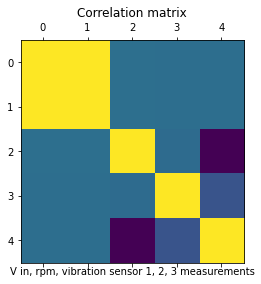

In [16]:
# sometimes it throws error
plt.matshow(data_0D_train_sampled.corr())
plt.title("Correlation matrix")
plt.xlabel("V in, rpm, vibration sensor 1, 2, 3 measurements")


High correlation between row 0 and 1 (rpm and Vin according to the data dictionary)
Nothing suprising here, as:

Voltage on the coils (armature) * machine constant = RPM

Still, don't forget that the Vin in the dataset is the motor controller's input, not the coltage on the coils.

There is a slight correlation between the 2 and 4 (1st and 3rd vibration sensor). If you check the measurement setup it's quite interesing. I assumed correlation between sensor 2 and 3. It turns out I was wrong.

#### Let's do the same with the test dataset

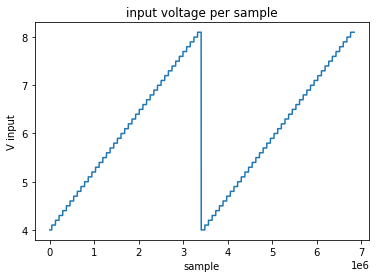

In [17]:
column_0 = data_0E_test_sampled.iloc[:, 0]
plt.plot(column_0);

plt.title("input voltage per sample")
plt.xlabel("sample")
plt.ylabel("V input");


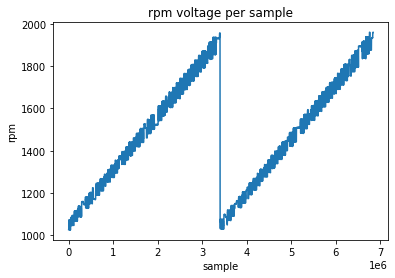

In [18]:
column_1 = data_0E_test_sampled.iloc[:,1]
plt.plot(column_1)

plt.title("rpm voltage per sample")
plt.xlabel("sample")
plt.ylabel("rpm");

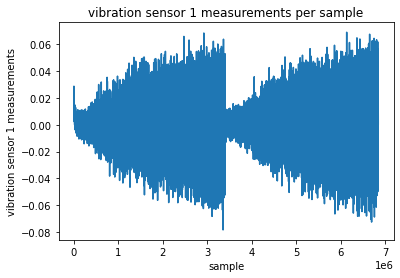

In [19]:
column_2 = data_0E_test_sampled.iloc[:,2]
plt.plot(column_2)

plt.title("vibration sensor 1 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 1 measurements");

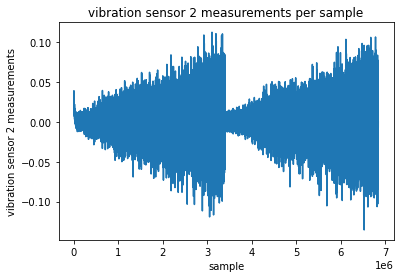

In [20]:
column_3 = data_0E_test_sampled.iloc[:,3]
plt.plot(column_3)

plt.title("vibration sensor 2 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 2 measurements");

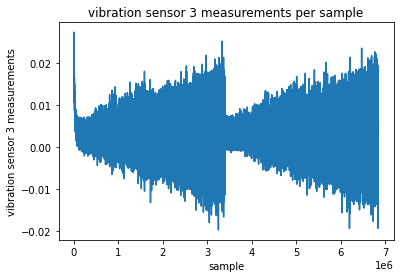

In [21]:
column_4 = data_0E_test_sampled.iloc[:,4]
plt.plot(column_4)

plt.title("vibration sensor 3 measurements per sample")
plt.xlabel("sample")
plt.ylabel("vibration sensor 3 measurements");

#### Correlation matrix on test data

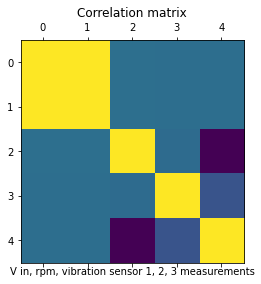

In [22]:
plt.matshow(data_0D_train_sampled.corr())

plt.title("Correlation matrix")
plt.xlabel("V in, rpm, vibration sensor 1, 2, 3 measurements");

#### I should go through the 4D, 4E subset pair, let's just check the rpm feature and the correlation matrix

In [23]:
data_4D_train_sampled = data_4D_train[::5]

data_4E_test_sampled = data_4E_test[::5]
data_4D_train_sampled.shape, data_4E_test_sampled.shape

((5268106, 5), (1372810, 5))

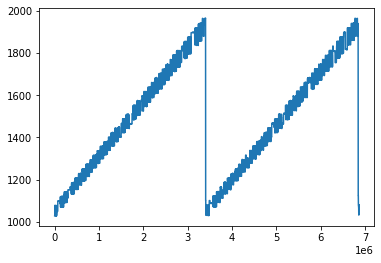

In [24]:
column_0 = data_4E_test_sampled.iloc[:, 1]
plt.plot(column_0);

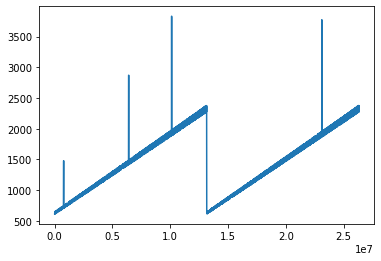

In [25]:
column_0 = data_4D_train_sampled.iloc[:, 1]
plt.plot(column_0);

More outliners here

At this point I read the paper's relevant part to check their figures. I didn't miss much, although downsampling the data for the figures was probably a mistake. I could have missed the outliners.

## Data preparation for the simple models

#### Down-sampling the data and merging of the subsets

In [26]:
# let's start with 0.1% of the data for fast early experiments
data_0D_train_sampled = data_0D_train[::1000].copy()
data_0E_test_sampled = data_0E_test[::1000].copy()
data_4D_train_sampled = data_4D_train[::1000].copy()
data_4E_test_sampled = data_4E_test[::1000].copy()

In [27]:
data_0D_train_sampled.shape, data_0E_test_sampled.shape

((26374, 5), (6844, 5))

In [28]:
data_4D_train_sampled.shape, data_4E_test_sampled.shape

((26341, 5), (6865, 5))

In [29]:
data_0D_train_sampled.shape

(26374, 5)

#### Supervised learning
Let's turn the dataset into a binary classification dataset
first add target values, 0 for the balanced and 1 unbalanced labels

In [30]:
# Add labels for the binary classification (supervised learning) 

data_0D_train_sampled['Target']= 0.0
data_0E_test_sampled['Target']= 0.0     
data_4D_train_sampled['Target']= 1.0       
data_4E_test_sampled['Target']= 1.0

In [31]:
# Check the results
data_0D_train_sampled.head()

,0,1,2,3,4,Target
0,2.0,646.61447,0.022309,0.036429,0.027755,0.0
1000,2.0,646.61447,0.020281,0.033019,0.026032,0.0
2000,2.0,646.61447,0.019073,0.030605,0.024254,0.0
3000,2.0,646.61447,0.016898,0.027570,0.022291,0.0
4000,2.0,618.47863,0.016670,0.026053,0.020912,0.0


In [32]:
data_4D_train_sampled.head()

,0,1,2,3,4,Target
0,2.0,615.37992,0.004704,0.029199,0.012696,1.0
1000,2.0,615.37992,0.003890,0.029494,0.012441,1.0
2000,2.0,615.37992,0.004114,0.025004,0.010996,1.0
3000,2.0,615.37992,0.004253,0.022691,0.010585,1.0
4000,2.0,640.45433,0.004597,0.021068,0.010074,1.0


In [33]:
# Ignore index because it's the same for both datasets
binary_training_ds = pd.concat([data_0D_train_sampled, data_4D_train_sampled], names=None, ignore_index=True, sort=False)
binary_training_ds.shape

(52715, 6)

In [34]:
# Merge the subsets
# Ignore index because it's the same for both datasets
binary_test_ds = pd.concat([data_0E_test_sampled, data_4E_test_sampled], names=None, ignore_index=True, sort=False)
binary_test_ds.shape

(13709, 6)

In [35]:
# Shuffle the training data
np.random.seed(42)
binary_training_ds = binary_training_ds.sample(frac=1)

#### Scale the features, encode the labels

In [36]:
# create target dataset for training data
binary_training_labels = binary_training_ds["Target"]
binary_training_labels.head()

9803     0.0
30457    1.0
4573     0.0
40724    1.0
3840     0.0
Name: Target, dtype: float64

In [37]:
# Create target dataset for test data
binary_test_labels = binary_test_ds["Target"]
binary_test_labels.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Target, dtype: float64

In [38]:
# Create features dataset for training data
binary_training_features = binary_training_ds.drop(["Target"], axis=1)
binary_training_features.head()

,0,1,2,3,4
9803,8.00,1858.67860,0.008092,-0.003484,0.003356
30457,4.50,1182.44670,-0.005440,-0.001523,0.004987
4573,4.80,1234.98730,0.000026,0.000273,0.002476
40724,2.70,791.16537,0.001225,0.001432,0.003611
3840,4.35,1103.23020,0.000322,0.000616,0.003036


In [39]:
# Create features dataset for test data
binary_test_features = binary_test_ds.drop(["Target"], axis=1)
binary_test_features.head()

,0,1,2,3,4
0,4.0,1026.9841,0.019882,0.034143,0.026740
1,4.0,1026.9841,0.017669,0.031412,0.024225
2,4.0,1026.9841,0.014933,0.027988,0.021998
3,4.0,1026.9841,0.014658,0.025411,0.021218
4,4.0,1073.0766,0.012665,0.024655,0.021702


In [40]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Normalize the data

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), [0, 1, 2, 3, 4])) # get all values between 0 and 1

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(binary_training_features)
    
# Transform training and test data with normalization (MinMaxScalar) 
binary_training_features_normal = ct.transform(binary_training_features)
binary_test_features_normal = ct.transform(binary_test_features)



In [41]:
# Check the results
pd.DataFrame(binary_training_features_normal).head()

,0,1,2,3,4
0,0.75000,0.386907,0.558315,0.483597,0.497280
1,0.31250,0.176655,0.482760,0.490071,0.526812
2,0.35000,0.192991,0.513279,0.496003,0.481348
3,0.08750,0.054999,0.519975,0.499829,0.501900
4,0.29375,0.152025,0.514930,0.497137,0.491494


In [42]:
pd.DataFrame(binary_training_features_normal).tail()

,0,1,2,3,4
52710,0.86250,0.446045,0.487253,0.492268,0.519105
52711,0.39375,0.203172,0.504034,0.495243,0.396464
52712,0.90000,0.491372,0.522997,0.537721,0.414511
52713,0.06250,0.041367,0.515149,0.496735,0.485666
52714,0.20000,0.117575,0.521613,0.496995,0.479750


In [43]:
pd.DataFrame(binary_test_features_normal).head()

,0,1,2,3,4
0,0.25,0.128319,0.624145,0.607833,0.920750
1,0.25,0.128319,0.611791,0.598815,0.875200
2,0.25,0.128319,0.596515,0.587511,0.834873
3,0.25,0.128319,0.594977,0.579001,0.820755
4,0.25,0.142650,0.583848,0.576506,0.829519


In [44]:
# Let's use shorter, standard variable names...
X_train = pd.DataFrame(binary_training_features_normal)
X_test = pd.DataFrame(binary_test_features_normal)

y_train = pd.DataFrame(binary_training_labels)
y_test = pd.DataFrame(binary_test_labels)

X_train.head()

,0,1,2,3,4
0,0.75000,0.386907,0.558315,0.483597,0.497280
1,0.31250,0.176655,0.482760,0.490071,0.526812
2,0.35000,0.192991,0.513279,0.496003,0.481348
3,0.08750,0.054999,0.519975,0.499829,0.501900
4,0.29375,0.152025,0.514930,0.497137,0.491494


In [45]:
X_train.shape

(52715, 5)

In [46]:
y_train.head()

,Target
9803,0.0
30457,1.0
4573,0.0
40724,1.0
3840,0.0


## Simple models 0.1% data, all features

In [47]:
# Trouble shooting
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52715 entries, 0 to 52714
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       52715 non-null  float64
 1   1       52715 non-null  float64
 2   2       52715 non-null  float64
 3   3       52715 non-null  float64
 4   4       52715 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [48]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52715 entries, 9803 to 15795
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  52715 non-null  float64
dtypes: float64(1)
memory usage: 823.7 KB


In [49]:
import tensorflow as tf
from tensorflow.keras import models, layers
import time # to measure how long training takes

In [50]:
tf.random.set_seed(42) # for reproducibility
start = time.time()

model_0_DNN = models.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_0_DNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                   metrics="accuracy")

history_0 = model_0_DNN.fit(X_train, 
                            y_train, 
                            epochs = 15, 
                            validation_data=(X_test, y_test))

end = time.time()


2022-10-29 09:18:49.100774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:18:49.192272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:18:49.193084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:18:49.194197: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/15
1648/1648 [==============================] - 6s 3ms/step - loss: 0.6344 - accuracy: 0.6337 - val_loss: 0.5646 - val_accuracy: 0.6771
Epoch 2/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5763 - accuracy: 0.6956 - val_loss: 0.4757 - val_accuracy: 0.7750
Epoch 3/15
1648/1648 [==============================] - 4s 3ms/step - loss: 0.5454 - accuracy: 0.7230 - val_loss: 0.4572 - val_accuracy: 0.7855
Epoch 4/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5270 - accuracy: 0.7348 - val_loss: 0.4466 - val_accuracy: 0.8012
Epoch 5/15
1648/1648 [==============================] - 4s 3ms/step - loss: 0.5184 - accuracy: 0.7413 - val_loss: 0.4319 - val_accuracy: 0.8095
Epoch 6/15
1648/1648 [==============================] - 4s 3ms/step - loss: 0.5155 - accuracy: 0.7412 - val_loss: 0.4318 - val_accuracy: 0.8119
Epoch 7/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5084 - accuracy: 0.7479 - val_loss: 0.4375 - val_accuracy:

the training took 85.04709649085999 seconds


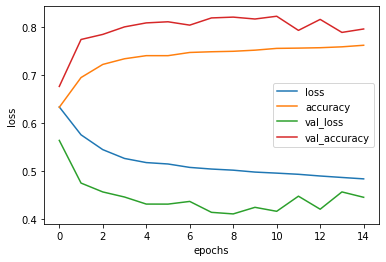

In [51]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_0.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

The simple DNN model seems to overfit at around 10 epochs, learning rate is too high

In [52]:
tf.random.set_seed(42)
start = time.time()

model_1_CNN = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Flatten(),
    layers.Dense(1, activation = "sigmoid")
])

model_1_CNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics="accuracy")

history_1 = model_1_CNN.fit(X_train, 
                            y_train, 
                            epochs = 15, 
                            validation_data=(X_test, y_test))

end = time.time()

Epoch 1/15


2022-10-29 09:20:15.588083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1648/1648 [==============================] - 12s 3ms/step - loss: 0.6791 - accuracy: 0.5829 - val_loss: 0.6372 - val_accuracy: 0.6414
Epoch 2/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.6304 - accuracy: 0.6559 - val_loss: 0.5643 - val_accuracy: 0.7228
Epoch 3/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.6031 - accuracy: 0.6799 - val_loss: 0.5394 - val_accuracy: 0.7278
Epoch 4/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5877 - accuracy: 0.6920 - val_loss: 0.5111 - val_accuracy: 0.7649
Epoch 5/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5759 - accuracy: 0.7041 - val_loss: 0.5031 - val_accuracy: 0.7623
Epoch 6/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5687 - accuracy: 0.7082 - val_loss: 0.5086 - val_accuracy: 0.7494
Epoch 7/15
1648/1648 [==============================] - 5s 3ms/step - loss: 0.5625 - accuracy: 0.7133 - val_loss: 0.4984 - val_accuracy: 0.7547
Ep

the training took 82.3233733177185 seconds


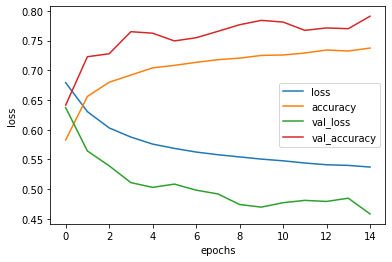

In [53]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_1.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

the CNN models could be trained for a few extra epochs, learning rate is too high

In [54]:
tf.random.set_seed(42)
start = time.time()

model_2_LSTM = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # expand input dimension to be compatible with LSTM
    layers.LSTM(128, activation="relu"),
    layers.Dense(1, activation = "sigmoid"),
])

model_2_LSTM.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics="accuracy")

history_2 = model_2_LSTM.fit(X_train, 
                            y_train, 
                            epochs = 15, 
                            validation_data=(X_test, y_test))

end = time.time()

Epoch 1/15
1648/1648 [==============================] - 10s 5ms/step - loss: 0.6806 - accuracy: 0.5805 - val_loss: 0.6322 - val_accuracy: 0.6868
Epoch 2/15
1648/1648 [==============================] - 9s 5ms/step - loss: 0.6308 - accuracy: 0.6587 - val_loss: 0.5627 - val_accuracy: 0.7266
Epoch 3/15
1648/1648 [==============================] - 10s 6ms/step - loss: 0.6045 - accuracy: 0.6827 - val_loss: 0.5413 - val_accuracy: 0.7273
Epoch 4/15
1648/1648 [==============================] - 9s 5ms/step - loss: 0.5897 - accuracy: 0.6906 - val_loss: 0.5133 - val_accuracy: 0.7641
Epoch 5/15
1648/1648 [==============================] - 9s 5ms/step - loss: 0.5778 - accuracy: 0.7030 - val_loss: 0.5058 - val_accuracy: 0.7610
Epoch 6/15
1648/1648 [==============================] - 10s 6ms/step - loss: 0.5701 - accuracy: 0.7079 - val_loss: 0.5125 - val_accuracy: 0.7431
Epoch 7/15
1648/1648 [==============================] - 9s 5ms/step - loss: 0.5635 - accuracy: 0.7144 - val_loss: 0.5002 - val_accura

the training took 140.20751976966858 seconds


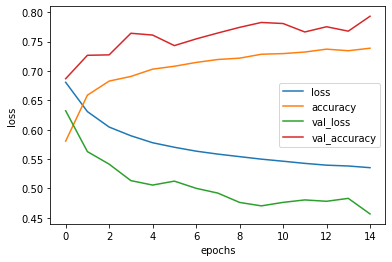

In [55]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

LSTM is same as CNN, some additional epoch could help, learning rate seems to be too high

#### summary of simple models 0.1% data, all features

All three has similar results, either the downsampled dataset is too small, the models are too simple, maybe the data isn't information rich enough.  

On the other hand the DNN model was trained in less time, thus the cheapest option.

The fact that all three models have very similar results leads to too small dataset.
It's an easy fix.



## Simple models 1% data, all features

### Data preparation, now in one block

In [56]:
np.random.seed(42)
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# let's start with 1% of the data for fast early experiments
data_0D_train_sampled = data_0D_train[::100].copy()
data_0E_test_sampled = data_0E_test[::100].copy()
data_4D_train_sampled = data_4D_train[::100].copy()
data_4E_test_sampled = data_4E_test[::100].copy()

# add labels for the binary classification (supervised learning) 

data_0D_train_sampled['Target']= 0.0
data_0E_test_sampled['Target']= 0.0     
data_4D_train_sampled['Target']= 1.0       
data_4E_test_sampled['Target']= 1.0

# ignore index because it's the same for both datasets
binary_training_ds = pd.concat([data_0D_train_sampled, data_4D_train_sampled], names=None, ignore_index=True, sort=False)

# merge the subsets

# ignore index because it's the same for both datasets
binary_test_ds = pd.concat([data_0E_test_sampled, data_4E_test_sampled], names=None, ignore_index=True, sort=False)

# shuffle the training data
binary_training_ds = binary_training_ds.sample(frac=1)

# create target dataset for training data
binary_training_labels = binary_training_ds["Target"]

# create target dataset for test data
binary_test_labels = binary_test_ds["Target"]

# create features dataset for training data
binary_training_features = binary_training_ds.drop(["Target"], axis=1)

# create features dataset for test data
binary_test_features = binary_test_ds.drop(["Target"], axis=1)

# normalize the data

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), [0, 1, 2, 3, 4])) # get all values between 0 and 1

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(binary_training_features)
    
# Transform training and test data with normalization (MinMaxScalar) 
binary_training_features_normal = ct.transform(binary_training_features)
binary_test_features_normal = ct.transform(binary_test_features)

# let's use shorter, standard variable names...
X_train = pd.DataFrame(binary_training_features_normal)
X_test = pd.DataFrame(binary_test_features_normal)

y_train = pd.DataFrame(binary_training_labels)
y_test = pd.DataFrame(binary_test_labels)

Same DNN, CNN, LSTM model as before with early stopping callback, it takes longer to train and I don't want overfitting  

Another change is the batch_size. In the dataset the motor revolves at least 600 time a minute (rpm), that's 10 revolution per second (or per 4096 sample). In 1024 sample there should be at least 2-3 revolution, probably more than enough.

In [57]:
tf.random.set_seed(42) # for reproducibility
start = time.time()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_3_DNN = models.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_3_DNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                   metrics="accuracy")

history_3 = model_3_DNN.fit(X_train, 
                            y_train, 
                            epochs = 100, 
                            batch_size = 1024,
                            validation_data=(X_test, y_test),
                            callbacks=[callback])

end = time.time()


Epoch 1/100
515/515 [==============================] - 2s 3ms/step - loss: 0.6334 - accuracy: 0.6580 - val_loss: 0.5156 - val_accuracy: 0.7564
Epoch 2/100
515/515 [==============================] - 2s 3ms/step - loss: 0.5621 - accuracy: 0.7211 - val_loss: 0.4642 - val_accuracy: 0.7908
Epoch 3/100
515/515 [==============================] - 2s 3ms/step - loss: 0.5311 - accuracy: 0.7399 - val_loss: 0.4472 - val_accuracy: 0.7926
Epoch 4/100
515/515 [==============================] - 1s 3ms/step - loss: 0.5082 - accuracy: 0.7538 - val_loss: 0.4417 - val_accuracy: 0.7948
Epoch 5/100
515/515 [==============================] - 2s 4ms/step - loss: 0.4922 - accuracy: 0.7632 - val_loss: 0.4173 - val_accuracy: 0.8163
Epoch 6/100
515/515 [==============================] - 2s 4ms/step - loss: 0.4814 - accuracy: 0.7698 - val_loss: 0.4078 - val_accuracy: 0.8246
Epoch 7/100
515/515 [==============================] - 2s 3ms/step - loss: 0.4751 - accuracy: 0.7725 - val_loss: 0.4060 - val_accuracy: 0.8286

the training took 35.061439514160156 seconds


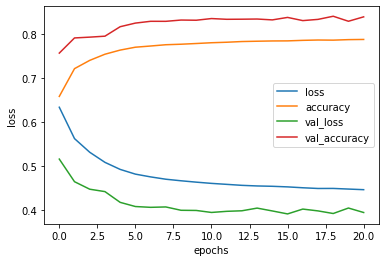

In [58]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_3.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [59]:
tf.random.set_seed(42)
start = time.time()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_4_CNN = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Flatten(),
    layers.Dense(1, activation = "sigmoid")
])

model_4_CNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics="accuracy")

history_4 = model_4_CNN.fit(X_train, 
                            y_train, 
                            epochs = 100, 
                            batch_size = 1024,
                            validation_data=(X_test, y_test),
                            callbacks=[callback])

end = time.time()

Epoch 1/100
515/515 [==============================] - 2s 3ms/step - loss: 0.6816 - accuracy: 0.6121 - val_loss: 0.6453 - val_accuracy: 0.7096
Epoch 2/100
515/515 [==============================] - 2s 3ms/step - loss: 0.6370 - accuracy: 0.6829 - val_loss: 0.5806 - val_accuracy: 0.7157
Epoch 3/100
515/515 [==============================] - 2s 3ms/step - loss: 0.6068 - accuracy: 0.6973 - val_loss: 0.5473 - val_accuracy: 0.7330
Epoch 4/100
515/515 [==============================] - 2s 3ms/step - loss: 0.5885 - accuracy: 0.7123 - val_loss: 0.5256 - val_accuracy: 0.7471
Epoch 5/100
515/515 [==============================] - 2s 3ms/step - loss: 0.5745 - accuracy: 0.7215 - val_loss: 0.5114 - val_accuracy: 0.7561
Epoch 6/100
515/515 [==============================] - 2s 3ms/step - loss: 0.5635 - accuracy: 0.7314 - val_loss: 0.4952 - val_accuracy: 0.7679
Epoch 7/100
515/515 [==============================] - 2s 4ms/step - loss: 0.5554 - accuracy: 0.7349 - val_loss: 0.4924 - val_accuracy: 0.7666

the training took 45.2246310710907 seconds


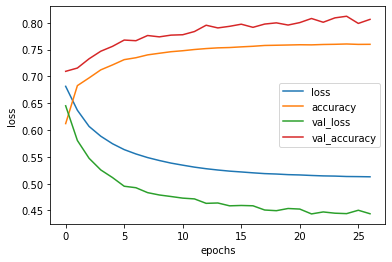

In [60]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_4.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [61]:
tf.random.set_seed(42)
start = time.time()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_5_LSTM = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # expand input dimension to be compatible with LSTM
    layers.LSTM(128, activation="relu"),
    layers.Dense(1, activation = "sigmoid"),
])

model_5_LSTM.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics="accuracy")

history_5 = model_5_LSTM.fit(X_train, 
                            y_train, 
                            epochs = 100, 
                            batch_size = 1024,
                            validation_data=(X_test, y_test),
                            callbacks=[callback])

end = time.time()

Epoch 1/100
515/515 [==============================] - 4s 6ms/step - loss: 0.6829 - accuracy: 0.6091 - val_loss: 0.6439 - val_accuracy: 0.7053
Epoch 2/100
515/515 [==============================] - 3s 5ms/step - loss: 0.6349 - accuracy: 0.6828 - val_loss: 0.5759 - val_accuracy: 0.7196
Epoch 3/100
515/515 [==============================] - 3s 6ms/step - loss: 0.6050 - accuracy: 0.6987 - val_loss: 0.5439 - val_accuracy: 0.7343
Epoch 4/100
515/515 [==============================] - 3s 6ms/step - loss: 0.5868 - accuracy: 0.7145 - val_loss: 0.5233 - val_accuracy: 0.7480
Epoch 5/100
515/515 [==============================] - 3s 6ms/step - loss: 0.5732 - accuracy: 0.7235 - val_loss: 0.5078 - val_accuracy: 0.7579
Epoch 6/100
515/515 [==============================] - 3s 6ms/step - loss: 0.5627 - accuracy: 0.7322 - val_loss: 0.4939 - val_accuracy: 0.7691
Epoch 7/100
515/515 [==============================] - 3s 6ms/step - loss: 0.5549 - accuracy: 0.7361 - val_loss: 0.4908 - val_accuracy: 0.7694

the training took 89.32056713104248 seconds


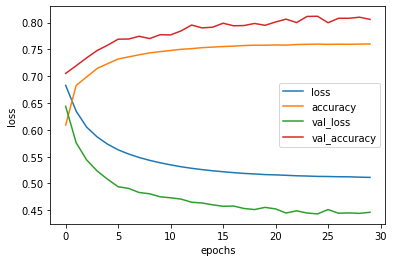

In [62]:
temp = end - start
print(f"the training took {temp} seconds")

# Plot history (also known as a loss curve)
pd.DataFrame(history_5.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

### Summary simple models, 1% data, all features
The larger batch size (1024 instead of the default 32) improved the speed of the training, it took about the same time to train with 10x data.  

The DNN scaled the best, the CNN and the LSTM models didn't improve.   

Normally I'd try more complex models here, but the goal was just to try out some simple models, so I turn my attention to the paper.

Note: using the same variables at the data preparation part is probably a bad practice.

finished here

### Re-creation of the CNN architecture from the paper 

Note: restart the session to avoid crash at this point.  
Use run/stop session and run after on this block.

The windowing part is from the paper's github notebook. I haven't checked the rest of the notebook at this point.   

I'll guess the hyperparameters from a different time forecasting notebook (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb),and later repeat the experiment with the hyperparameters from the paper's github notebook.

I only use the D0-D4, E0-E4, data subset pair here

In [63]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np

In [64]:
skip = 50000

data_0D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv', skiprows = skip, header=None)
#data_1D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv', skiprows = skip, header=None)
#data_2D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv', skiprows = skip, header=None)
#data_3D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv', skiprows = skip, header=None)
data_4D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv', skiprows = skip, header=None)

data_0E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv', skiprows = skip, header=None)
#data_1E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv', skiprows = skip, header=None)
#data_2E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv', skiprows = skip, header=None)
#data_3E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv', skiprows = skip, header=None)
data_4E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv', skiprows = skip, header=None)

In [65]:
# due to the windowing I can use the whole dataset
data_0D_train_sampled = data_0D_train
data_0E_test_sampled = data_0E_test
data_4D_train_sampled = data_4D_train
data_4E_test_sampled = data_4E_test

# let's use only vibration sensor 1
data_0D_train_sampled = data_0D_train_sampled[2] # 3rd column is the vibration 1 sensor data-feed
data_0E_test_sampled = data_0E_test_sampled[2]
data_4D_train_sampled = data_4D_train_sampled[2]
data_4E_test_sampled = data_4E_test_sampled[2]

In [66]:
data_0D_train_sampled.max()

0.10103703

In [67]:
data_0D_train_sampled.shape[0]

26373296

In [68]:
# function for windowing the data
window = 4096
def windowing(data, window):
    n = int(np.floor(data.shape[0] / window)) # number of batches
    data = data[:n * window]
    data_reshaped = data.values.reshape(n, window)
    return pd.DataFrame(data_reshaped)
windowing(data_0D_train_sampled, window)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.022309,0.021607,0.022007,0.021794,0.021769,0.022249,0.021987,0.022095,0.022128,0.021838,...,0.016465,0.016191,0.016048,0.016168,0.016321,0.016043,0.016216,0.016044,0.016418,0.016212
1,0.015911,0.016222,0.015924,0.016122,0.015638,0.015999,0.016446,0.016429,0.016470,0.016180,...,0.012234,0.011767,0.012295,0.011928,0.011916,0.012276,0.012093,0.012738,0.012436,0.012710
2,0.012711,0.012282,0.012311,0.012122,0.012103,0.012515,0.012317,0.011957,0.012355,0.012488,...,0.009589,0.009817,0.009912,0.009768,0.009569,0.009421,0.009521,0.009477,0.009339,0.009872
3,0.009648,0.009034,0.009407,0.008970,0.009658,0.009727,0.009511,0.009456,0.009693,0.009798,...,0.007786,0.007659,0.006849,0.006819,0.007820,0.007923,0.007235,0.007281,0.007640,0.008422
4,0.008172,0.007472,0.007648,0.007395,0.008004,0.007365,0.007322,0.007362,0.007489,0.007763,...,0.006610,0.006821,0.006044,0.006121,0.006462,0.006194,0.006309,0.006109,0.006039,0.006450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,0.000573,0.000165,0.000031,0.000190,0.000057,0.000801,0.000913,0.001233,0.001435,0.000863,...,0.001167,0.000495,0.000224,0.000374,-0.000116,0.000420,0.000603,0.000901,0.001280,0.001192
6434,0.000979,0.000792,0.000411,0.000459,0.000532,0.000241,0.000727,0.000687,0.000637,0.001210,...,0.000892,0.000756,0.001379,0.000927,0.000852,0.000323,0.000007,0.000138,0.000259,0.000498
6435,0.000641,0.001174,0.001119,0.001299,0.001379,0.000719,0.001005,-0.000044,-0.000020,0.000395,...,0.000412,0.000118,0.000747,0.000641,0.000422,0.000806,0.000676,0.001044,0.000826,0.000416
6436,0.000851,0.000664,0.000044,-0.000199,-0.000660,0.000324,0.001323,0.003614,0.000341,-0.000776,...,0.000776,0.000645,0.000837,0.001241,0.001286,0.000867,0.000225,0.000249,0.000373,0.000935


In [69]:
# window the data
window = 4096
data_0D_train_sampled = windowing(data_0D_train_sampled, window)
data_0E_test_sampled = windowing(data_0E_test_sampled, window)
data_4D_train_sampled = windowing(data_4D_train_sampled, window)
data_4E_test_sampled = windowing(data_4E_test_sampled, window)

In [70]:
# for the binary classification

data_0D_train_sampled['Target']= 0.0
data_0E_test_sampled['Target']= 0.0     
data_4D_train_sampled['Target']= 1.0       
data_4E_test_sampled['Target']= 1.0

In [71]:
# ignore index because it's the same for both datasets
binary_training_ds = pd.concat([data_0D_train_sampled, data_4D_train_sampled], names=None, ignore_index=True, sort=False)
binary_test_ds = pd.concat([data_0E_test_sampled, data_4E_test_sampled], names=None, ignore_index=True, sort=False)

# get labels
binary_training_labels = binary_training_ds["Target"]
binary_test_labels = binary_test_ds["Target"]
# get features
binary_training_features = binary_training_ds.drop(["Target"], axis=1)
binary_test_features = binary_test_ds.drop(["Target"], axis=1)


# let's use shorter variable names...
X_train = pd.DataFrame(binary_training_features)
X_test = pd.DataFrame(binary_test_features)

y_train = pd.DataFrame(binary_training_labels)
y_test = pd.DataFrame(binary_test_labels)


In [72]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.022309,0.021607,0.022007,0.021794,0.021769,0.022249,0.021987,0.022095,0.022128,0.021838,...,0.016465,0.016191,0.016048,0.016168,0.016321,0.016043,0.016216,0.016044,0.016418,0.016212
1,0.015911,0.016222,0.015924,0.016122,0.015638,0.015999,0.016446,0.016429,0.016470,0.016180,...,0.012234,0.011767,0.012295,0.011928,0.011916,0.012276,0.012093,0.012738,0.012436,0.012710
2,0.012711,0.012282,0.012311,0.012122,0.012103,0.012515,0.012317,0.011957,0.012355,0.012488,...,0.009589,0.009817,0.009912,0.009768,0.009569,0.009421,0.009521,0.009477,0.009339,0.009872
3,0.009648,0.009034,0.009407,0.008970,0.009658,0.009727,0.009511,0.009456,0.009693,0.009798,...,0.007786,0.007659,0.006849,0.006819,0.007820,0.007923,0.007235,0.007281,0.007640,0.008422
4,0.008172,0.007472,0.007648,0.007395,0.008004,0.007365,0.007322,0.007362,0.007489,0.007763,...,0.006610,0.006821,0.006044,0.006121,0.006462,0.006194,0.006309,0.006109,0.006039,0.006450


In [73]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12868, 4096), (12868, 1), (3345, 4096), (3345, 1))

It's a simple one input, one ouput model, with the layers in sequence, so I'll use the Sequential API

In [74]:
CNN_block = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.MaxPooling1D(pool_size=2, padding="same"),
])


In [75]:
FC_block = models.Sequential([
    layers.Flatten(),
    layers.Dense(128),
    layers.LeakyReLU(),
])

In [76]:
tf.random.set_seed(42)

model_6 = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirement
    CNN_block,
    CNN_block,
    FC_block,
    layers.Dense(1, activation="sigmoid") # output layer
])
model_6.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])
model_6.fit(X_train,
           y_train,
           epochs= 30,
           validation_data=(X_test, y_test))

2022-10-29 09:29:04.346649: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 421658624 exceeds 10% of free system memory.
2022-10-29 09:29:04.943673: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 421658624 exceeds 10% of free system memory.


Epoch 1/30
403/403 [==============================] - 3s 6ms/step - loss: 0.6135 - accuracy: 0.6180 - val_loss: 0.6087 - val_accuracy: 0.7737
Epoch 2/30
403/403 [==============================] - 2s 5ms/step - loss: 0.4798 - accuracy: 0.7720 - val_loss: 0.4099 - val_accuracy: 0.8338
Epoch 3/30
403/403 [==============================] - 2s 5ms/step - loss: 0.3992 - accuracy: 0.8002 - val_loss: 0.3853 - val_accuracy: 0.8433
Epoch 4/30
403/403 [==============================] - 2s 6ms/step - loss: 0.3425 - accuracy: 0.8189 - val_loss: 0.3871 - val_accuracy: 0.8383
Epoch 5/30
403/403 [==============================] - 2s 5ms/step - loss: 0.2932 - accuracy: 0.8526 - val_loss: 0.4027 - val_accuracy: 0.8332
Epoch 6/30
403/403 [==============================] - 2s 5ms/step - loss: 0.2503 - accuracy: 0.8829 - val_loss: 0.4520 - val_accuracy: 0.8341
Epoch 7/30
403/403 [==============================] - 2s 6ms/step - loss: 0.2234 - accuracy: 0.8987 - val_loss: 0.4880 - val_accuracy: 0.8263
Epoch 

In [77]:
model_6.evaluate(X_test, y_test)

105/105 [==============================] - 0s 3ms/step - loss: 0.8478 - accuracy: 0.8161


[0.8478348255157471, 0.8161435127258301]

In [78]:
model_6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 4096)           0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 1, 128)            2622080   
_________________________________________________________________
sequential_7 (Sequential)    (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,638,721
Trainable params: 2,638,465
Non-trainable params: 256
_________________________________________________________________


After a few days I give up with the the Sequential model. I figured out how to make it work with functional API, but it's be the same as re-typing the paper's code with different hyper-parameters, what is kind of pointless.

### Let's start again, this time I re-type the paper's github code 

due memory contraints I won't use the 4E-4D subsets

In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [80]:
skip = 50000

data_0D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv', skiprows = skip, header=None)
data_1D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv', skiprows = skip, header=None)
data_2D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv', skiprows = skip, header=None)
data_3D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv', skiprows = skip, header=None)
#data_4D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv', skiprows = skip, header=None)

data_0E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv', skiprows = skip, header=None)
data_1E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv', skiprows = skip, header=None)
data_2E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv', skiprows = skip, header=None)
data_3E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv', skiprows = skip, header=None)
#data_4E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv', skiprows = skip, header=None)

#### Data preparation

In [ ]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 2 # vibration sensor 1
window = 4096 

def get_windowed_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_windowed_features(data_0D_train[sensor], "no_unbalance")
X1,y1 = get_windowed_features(data_1D_train[sensor], "unbalance")
X2,y2 = get_windowed_features(data_2D_train[sensor], "unbalance")
X3,y3 = get_windowed_features(data_3D_train[sensor], "unbalance")
#X4,y4 = get_windowed_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3,]) #X4])
y=np.concatenate([y0, y1, y2, y3,]) #y4])

X0_val, y0_val = get_windowed_features(data_0E_test[sensor], "no_unbalance")
X1_val, y1_val = get_windowed_features(data_1E_test[sensor], "unbalance")
X2_val, y2_val = get_windowed_features(data_2E_test[sensor], "unbalance")
X3_val, y3_val = get_windowed_features(data_3E_test[sensor], "unbalance")
#X4_val, y4_val = get_windowed_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val,]) #X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val,]) #y4_val])


In [ ]:
print(X.shape, y.shape, X_val.shape, y_val.shape)


In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_test_ratio)
X_train = np.reshape(X_train, (X_train.shape[0], X_test.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#### Convolutional Neural Net (CNN)

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

In [ ]:
# The test set isn't shuffled, so it can be sliced into E0, E1, E2, etc. subsets 
# to check where the model performs better or worse 
X_val_1 = X_val[:len(y0_val),:,:] 
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val),:,:]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val),:,:]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val),:,:]
#X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
#                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:,:]

In [ ]:
model_path = '../models'

In [ ]:
# this part deals with unbalance datasets, it isn't necessary in all experiments, 
# instead of down-sampling the unbalanced subset it changes the weights of them
weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 128
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 15 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*10,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                 verbose=0, save_best_only=True, mode='min')
    
    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

    classifier.fit(X_train, 
                   y_train, 
                   epochs = n_epochs, 
                   batch_size = 64,
                   validation_data=(X_test, y_test), 
                   callbacks=[checkpoint], 
                   class_weight=class_weight, verbose = 0)
    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)


In [ ]:
tf.random.set_seed(42)
for i in range(1,5):  #it was 1,5
    train_models(i)

In [ ]:
accuracies = []
accuracies_all = []
for layer_n in range(1,5):
    
    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    
    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    #val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4,] #val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

In [ ]:
accuracies_all


In [ ]:
accuracies

### Let's compare my simple DNN model to the paper's CNN models with the same evaluation methods

In [ ]:
from tensorflow.keras import models, layers 

tf.random.set_seed(42) # for reproducibility

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_8_DNN = models.Sequential([
    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_8_DNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                   metrics="accuracy")

history_8 = model_8_DNN.fit(X_train, 
                            y_train, 
                            epochs = 100, 
                            batch_size = 32,
                            validation_data=(X_test, y_test),
                            callbacks=[callback])



In [ ]:
model_i = model_8_DNN
    
accuracies = []
accuracies_all = []

    
filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
model_i = load_model(filepath)
    
val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
#val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
val_acc_all = model_i.evaluate(X_val, y_val)[1]
accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4,] #val_acc_5]
accuracies.append(accuracies_layer_i)
accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

In [ ]:
accuracies

In [ ]:
accuracies_all

94% accuracy for the best of the paper, 
86.4% for my simple model.

It's important to note here that I ran paper's model a few times and result vary many percent points.

### Before we go to other models, does the window size have major effect on acc?

window = 2048 is the only parameter I changed

note: if you run the notebook from the "Let's start again, this time reuse the paper's github code" part it'll probably crash here without restart

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

In [ ]:
skip = 50000

data_0D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv', skiprows = skip, header=None)
data_1D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv', skiprows = skip, header=None)
data_2D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv', skiprows = skip, header=None)
data_3D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv', skiprows = skip, header=None)
#data_4D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv', skiprows = skip, header=None)

data_0E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv', skiprows = skip, header=None)
data_1E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv', skiprows = skip, header=None)
data_2E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv', skiprows = skip, header=None)
data_3E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv', skiprows = skip, header=None)
#data_4E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv', skiprows = skip, header=None)

In [ ]:
labels = {'no_unbalance': 0, 'unbalance':1}
sensor = 2 # first vibration sensor
window = 2048


def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data_0D_train[sensor], "no_unbalance")
X1,y1 = get_features(data_1D_train[sensor], "unbalance")
X2,y2 = get_features(data_2D_train[sensor], "unbalance")
X3,y3 = get_features(data_3D_train[sensor], "unbalance")
#X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3,]) #X4])
y=np.concatenate([y0, y1, y2, y3,]) #y4])

X0_val, y0_val = get_features(data_0E_test[sensor], "no_unbalance")
X1_val, y1_val = get_features(data_1E_test[sensor], "unbalance")
X2_val, y2_val = get_features(data_2E_test[sensor], "unbalance")
X3_val, y3_val = get_features(data_3E_test[sensor], "unbalance")
#X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val,]) #X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val,]) #y4_val])


In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_test_ratio)
X_train = np.reshape(X_train, (X_train.shape[0], X_test.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
import tensorflow as tf

In [ ]:
weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}
tf.random.set_seed(42)

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 128
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 15 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*10,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                 verbose=0, save_best_only=True, mode='min')
    
    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

    classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint], 
                   class_weight=class_weight, verbose = 0)
    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)


In [ ]:
model_path = '../models'

In [ ]:
tf.random.set_seed(42)

for i in range(1,5):  #it was 1,5
    train_models(i)

In [ ]:
X_val_1 = X_val[:len(y0_val),:]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val),:]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val),:]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val),:]
#X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
#                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:,:]

In [ ]:
accuracies = []
accuracies_all = []
for layer_n in range(1,5):
    
    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    
    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    #val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4,] #val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

In [ ]:
accuracies

In [ ]:
accuracies_all

In [ ]:
from tensorflow.keras import models, layers 

tf.random.set_seed(42) # for reproducibility

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_9_DNN = models.Sequential([
    layers.Flatten(),
    layers.Dense(100, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_9_DNN.compile(loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                   metrics="accuracy")

history_9 = model_9_DNN.fit(X_train, 
                            y_train, 
                            epochs = 100, 
                            batch_size = 32,
                            validation_data=(X_test, y_test),
                            callbacks=[callback])



In [ ]:
model_i = model_9_DNN
    
accuracies = []
accuracies_all = []

    
filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
model_i = load_model(filepath)
    
val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
#val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
val_acc_all = model_i.evaluate(X_val, y_val)[1]
accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4,] #val_acc_5]
accuracies.append(accuracies_layer_i)
accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

In [ ]:
accuracies

In [ ]:
accuracies_all

well, it some positive effect on the DNN network, not much on the CNN.  

Running with window size 1024 has a major negative effect on the CNN. Not suprising, because it decrease the trainable parameters too much.

## DNN with FFT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

In [ ]:
skip = 50000
col_list = [2] # read only the needed columns (vibration sensor 1) 
# of the csv to save on memory

data_0D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv', 
                            skiprows = skip, header=None, usecols = col_list) 
data_1D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv', 
                            skiprows = skip, header=None, usecols = col_list)
data_2D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv', 
                            skiprows = skip, header=None, usecols = col_list)
data_3D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv', 
                            skiprows = skip, header=None, usecols = col_list)
#data_4D_train = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv', 
#                            skiprows = skip, header=None, usecols = col_list)

data_0E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv', 
                           skiprows = skip, header=None, usecols = col_list)
data_1E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv', 
                           skiprows = skip, header=None, usecols = col_list)
data_2E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv', 
                           skiprows = skip, header=None, usecols = col_list)
data_3E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv', 
                           skiprows = skip, header=None, usecols = col_list)
#data_4E_test = pd.read_csv('/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv', 
#                           skiprows = skip, header=None, usecols = col_list)

In [ ]:
labels = {'no_unbalance': 0, 'unbalance' : 1}
window = 4096 
sensor = 2 # vibration sensor 1

def get_features(data, label):
    """this function returns the windowed pandas series as a examples times window 
    shaped matrix"""
    n = int(np.floor(len(data)/window))
    data = data[:(int(n)*window)]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X, y

X0,y0 = get_features(data_0D_train[sensor], "no_unbalance")
X1,y1 = get_features(data_1D_train[sensor], "unbalance")
X2,y2 = get_features(data_2D_train[sensor], "unbalance")
X3,y3 = get_features(data_3D_train[sensor], "unbalance")
#X4,y4 = get_features(data_4D_train[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3]) #,X4])
y=np.concatenate([y0, y1, y2, y3]) #,y4])

X0_val, y0_val = get_features(data_0E_test[sensor], "no_unbalance")
X1_val, y1_val = get_features(data_1E_test[sensor], "unbalance")
X2_val, y2_val = get_features(data_2E_test[sensor], "unbalance")
X3_val, y3_val = get_features(data_3E_test[sensor], "unbalance")
#X4_val, y4_val = get_features(data_4E_test[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val]) #,X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val]) #,y4_val])

In [ ]:
X.shape, X_val.shape, y.shape, y_val.shape

In [ ]:
from sklearn.model_selection import train_test_split
train_test_split_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 1 - train_test_split_ratio,
                                                    random_state=42)

#### Fourier Transformation recap
If you have a periodic signal, like a sin() function,
something the deeplearning models can't really handle
you can turn it into two numbers, its max size (amplitude) and that how many times
it goes 360 degrees per second (frequency).

You can do it with any periodic signal and break it down into a combination of sin and cos functions and get amplitude and frequency for each of them.

We are dealing with a rotating weight here, and a 1D sensor, so you can be sure
there is at least one sin or cos in the equation.

In [ ]:
X_fft = np.abs(np.fft.rfft(X, axis=1))[:,:int(window/2)]
X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))[:,:int(window/2)]
X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))[:,:int(window/2)]
X_val_fft = np.abs(np.fft.rfft(X_val, axis=1))[:,:int(window/2)]

X_fft[:,0]=0 # why zero out the first example?
X_train_fft[:,0]=0
X_test_fft[:,0]=0
X_val_fft[:,0]=0
                    

In [ ]:
# input
plt.plot(X[:,:1])
plt.xlabel("Index of sample")
plt.ylabel("Signal from the vibration sensor")
plt.title("Data before FastFourierTransform");

In [ ]:
# check the results
plt.plot(X_fft[:,:2])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Data after FastFourierTransform");

In [ ]:
print(X_train_fft.shape, X_test_fft.shape, X_val_fft.shape)

In [ ]:
# fit on training only to avoid data leakage
scaler = RobustScaler(quantile_range=(5, 95)).fit(X_train_fft) # it excludes the outliners

X_fft_sc = scaler.transform(X_fft)
X_train_fft_sc = scaler.transform(X_train_fft)
X_test_fft_sc = scaler.transform(X_test_fft)
X_val_fft_sc = scaler.transform(X_val_fft)

#### Evaluation

In [ ]:
X_val_fft_1 = X_val_fft_sc[:len(y0_val),:]
y_val_1 = y_val[:len(y0_val)]
X_val_fft_2 = X_val_fft_sc[len(y0_val):len(y0_val)+len(y1_val),:]
y_val_2 = y_val[len(y0_val):len(y0_val)+len(y1_val)]
X_val_fft_3 = X_val_fft_sc[len(y0_val)+len(y1_val):len(y0_val)+
                           len(y1_val)+len(y2_val),:]
y_val_3 = y_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val)]
X_val_fft_4 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val),:]
y_val_4 = y_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)]
#X_val_fft_5 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
#                           len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:]
#y_val_5 = y_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+len(y1_val)+
#                len(y2_val)+len(y3_val)+len(y4_val)]


In [ ]:
model_path = '../models'

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras. optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

# added earlyStopCallback to the original model to save training time 
# added dropout, because at one run the model didn't generalize well, 
# I got much worse results at the evaluation, than with the test set 

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 11)

weight_for_0 = len(y)/(2*len([y==0]))
weight_for_1 = len(y)/(2*len([y==1]))
class_weight = {0: weight_for_0, 1 : weight_for_1}

epochs = 100
for i in range(5):
    X_input = Input(shape=(X_train_fft.shape[1],), name = "input layer")
    x = X_input
    for j in range(i):
        x = Dense(units = 1024, activation="linear")(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = Dropout(0.2)(x)
    X_output = Dense(units=1, activation="sigmoid")(x)
    model_i = Model(X_input, X_output)

    best_model_file_path = f"{model_path}/fnn_fcn_{i}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_file_path, 
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')
    
    model_i.compile(optimizer=Adam(learning_rate = 0.0005),
                   loss= "binary_crossentropy",
                   metrics=["accuracy"]) # ,"Recall", "Precision"
    
    model_i.fit(X_train_fft_sc, 
                y_train,
                epochs = epochs,
                validation_data = (X_test_fft_sc, y_test),
                callbacks=[checkpoint, early_stop],
                class_weight=class_weight)
    

In [ ]:
from tensorflow.keras.models import load_model

model_loss = []
model_acc = []
model_accs_per_class = []

for i in range(5):
    best_model_filepath = f"{model_path}/fnn_fcn_{i}_layers.h5"
    model_i = load_model(best_model_filepath)
    train_acc_ges = model_i.evaluate(X_train_fft_sc, y_train)
    val_acc_ges = model_i.evaluate(X_val_fft_sc, y_val)
    
    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
#    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    
    model_acc.append([train_acc_ges[1], val_acc_ges[1]])
    model_loss.append([train_acc_ges[0], val_acc_ges[0]])
    model_accs_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4])#, val_acc_5])


#### Binary classification trade-off
It's a system for prevention, but what is better, alert even when there is no unbalance (false positives can go up) or it shouldn't alert if there is unbalance (false negatives can go up).

with other word alert sometimes with nothing or not alert even if there is some chance for trouble.

An interesting trade-off for any binary classification, from the problem alone
I don't know what is better. I'd need the cost of the shutdown and the cost of the procedure to replace the part and the part itself to answer that.

#### Why did the FFT work so well? Domain knowledge summary
If you think about it...  
The reading of the vibration sensors is something like that:

With the rotating shaft balanced the centrifugal forces cancel out each other.  
If there is unbalance, thus it creates centrifugal force.  

Fc = m * range * angular velocity(squared) 

The unbalancing weight rotates with the shaft, so in 2D,  
the vibration sensor pick up the 1D projection (like shadow of the clock-hand)  
of that, so the equation changes to:  

Fsensor = Fc * sin(alpha) #if the sensor is in vertical position, cos(alpha) if it is horizontal  

where alpha is the 'position' of the shaft

If you apply Fourier transformation of Fsensor, as I mentioned before  
you get back amplitude, what is the centrifugal force in this case. 

It also implies the frequency, in this case angular speed. 
(as ang speed = 2* pi*  freq)

Deeplearning models are quite bad with trigonometry, like sin, cos waves and squares, that's why you need Fourier transformation here.  
In this case the four fully connected (Dense) layer manages to figure it out quite accurately.

At least this is my theory, If I'm wrong I'm happy to fix the notes here.